# Computing Topological Features of Embedding Point Clouds

In [1]:
from _collections_abc import Iterable

import glob
import re
import json

import numpy as np
import gudhi
import matplotlib.pyplot as plt
import os  
from IPython.display import clear_output

In [2]:
def parse_json_filename(filename:str) -> tuple[str, list[tuple[str]]]:
    '''
    Parse JSON filesnames produced by CodeEmbeddingsGenerator.py
    into the classes, methods, and tokens they are located in.

    Args:
        filename: JSON filename to parse.
    
    Returns:
        level: Coding level of granularity (i.e., "class", "method", "token")
        identifiers: An ordered list of the nested classes, methods, and/or token.
    '''
    f = filename[:-5]
    nesting = []
    for m in re.finditer(r'(^|_)(c\.|m\.|token)', f):
        if (m.group() == 'c.') or (m.group() == '_c.'): level = 'class'
        elif (m.group() == 'm.') or (m.group() == '_m.'): level = 'method'
        elif (m.group() == 'token') or (m.group() == '_token'): level = 'token'
        else:
            print(f'Something has gone wrong! \n\tFilename: {filename}\n\tMatch: {m}')
            level = ''

        nesting.append((m.start(), m.end(), level))

    identifiers = []
    for i in range(1, len(nesting)):
        end = nesting[i]
        start = nesting[i-1]

        # Get identifier name and duplicate number 
        # (or just duplicate number if its a token)
        name = f[start[1] : end[0]]
        identifiers.append((name, start[2])) # Store name and level

    # Get last name and level
    last = nesting[-1]
    name = f[last[1]:] 
    identifiers.append((name, last[2]))

    # Return embedding level and parsing results
    return last[2], identifiers


def get_embedding_paths(sub_dirs:Iterable[str] = ['data'], 
                        levels:Iterable[str] = ['class', 'method', 'token'],
                        id_nestings:Iterable[tuple[str]] = []
                        ) -> tuple[list[str], list[str]]:
    '''
    Return file paths for JSON files created by CodeEmbeddingsGenerator.py.
    Collects all JSON files in a data folder by default.

    sub_dirs: Paths to subdirectories within the data folder to collect the JSON files from.
    levels: Embedding levels to collect (i.e., "class", "method", "token").
    id_nestings: Ordered lists of classes and/or methods that the code fragments associated with 
        the embeddings must be found in. The format must match that of the the 2nd output of 
        parse_json_filename().

    Returns:
        embed_paths: Paths to the JSON files.
        embed_levels: Embedding levels associated with each path in embed_paths.
    '''
    for level in levels:
        if level not in ('class', 'method', 'token'):
            print(f'Warning: Invalid level name "{level}".')
            
    embed_paths = []
    embed_levels = []
    for dir in sub_dirs:
        # Search through all JSON files
        for path in glob.glob(dir + '/**/*.json', recursive=True):
            filename = re.split(r'\\|/', path)[-1] # Get filename (and file extension)
            level, identifiers = parse_json_filename(filename) # Get embedding level and the nesting
            # Collect paths to embeddings of specified levels
            if level in levels:
                if len(id_nestings) == 0:
                    embed_paths.append(path)
                    embed_levels.append(level)
                    continue
                # Collect paths to embeddings that are nested in the specified classes and/or methods
                for nesting in id_nestings:
                    if nesting == identifiers[:len(nesting)]:
                        embed_paths.append(path)
                        embed_levels.append(level)
                        break
    return embed_paths, embed_levels


def paths_to_data(paths:Iterable[str], to_ndarray:bool = False) -> dict:
    '''
    Takes a list of directory paths to JSON files generated by CodeEmbeddingsGenerator.py, 
    then loads the data and compiles them into a single dictionary.

    Args:
        paths: The list of directory paths to JSON files.
        to_ndarray: If True, return each set of data as NumPy arrays; otherwise return as lists

    Returns:
        data: A dataset of embeddings, the associated identifier/token name, 
            the start and end indices for parsing the original code fragment,
            and the directory path to the JSON file.
    '''
    data = {'embeds':list(), 'names':list(), 'spans':list(), 'paths':list()}
    for path in paths:
        file = json.load(open(path, 'r'))
        data['embeds'].append(file[0][0]) # Embedding
        data['names'].append(file[1]) # Identifier or token name
        data['spans'].append(file[2]) # Start and end indices in source code
        data['paths'].append(path) # Path to file

    if to_ndarray:
        # Turn lists into numpy arrays
        for key in data.keys():
            data[key] = np.array(data[key])
    return data

In [3]:
def plot_persistence(persist):
    fig, ax = plt.subplots(ncols=2)
    fig.set_figwidth(10)
    fig.set_figheight(4)
    gudhi.plot_persistence_diagram(persist, axes=ax[0])
    gudhi.plot_persistence_barcode(persist, axes=ax[1])
    return fig, ax

def compute_betti_numbers(simp_tree, persist=None):
    if persist is None:
        persist = simp_tree.persistence()
        
    if persist == [(0, (0.0, np.inf))]*len(persist):
        # This occurs when max_edge_length is too low, and simplicial complex is all verticies and no edges
        # Do not call betti_numbers(), lest the kernel crashes
        return [len(persist)] # \beta_0 = number of embeddings
    else:        
        return simp_tree.betti_numbers()

In [9]:
# List of all directories to folders of JSON files
# These are the Java files in the original codebase
all_java_files = list(set(['/'.join(dir.split('/')[:-1]) for dir in glob.glob("/home/cxiong/CSCI420_05/data/**/*.json", recursive=True)]))
all_java_files = sorted(all_java_files)

In [5]:
# List of all directories of folders that don't have JSON files
# These are the folders in the original codebase
all_folders = glob.glob("/home/cxiong/CSCI420_05/data/**/*", recursive=True)
all_folders = [path for path in all_folders if path[-5:] != '.json'] # Remove all JSON files
all_folders = [path for path in all_folders if path.split('/')[-1][0].islower()] # Remove all "Java" folders

# All Classes

In [10]:
paths, _ = get_embedding_paths(sub_dirs=['/home/cxiong/CSCI420_05/data/ivy'], levels=['class'])
data = paths_to_data(paths)

In [11]:
# 2 minutes
tree = gudhi.RipsComplex(points=data['embeds'], max_edge_length=40).create_simplex_tree(max_dimension=3)
persist = tree.persistence()

Betti numbers: [26, 3, 0]


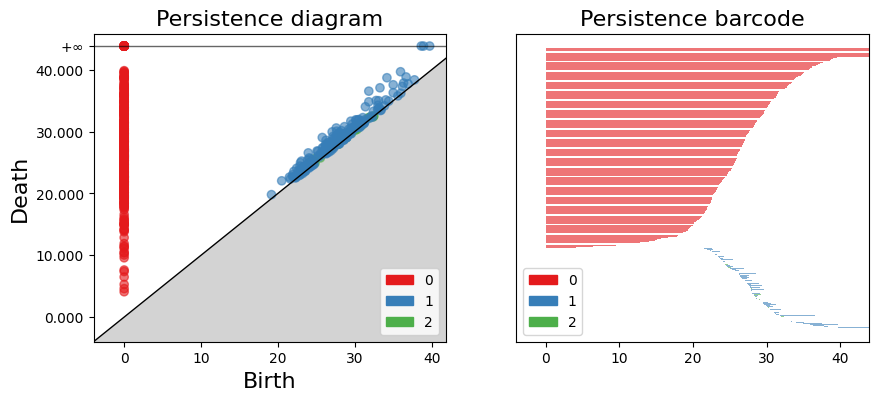

In [12]:
print("Betti numbers:", compute_betti_numbers(tree, persist))
plot_persistence(persist)
plt.show()

In [19]:
tree1 = gudhi.RipsComplex(points=data['embeds'], max_edge_length=50).create_simplex_tree(max_dimension=2)
persist1 = tree1.persistence()

Betti numbers: [1, 0]


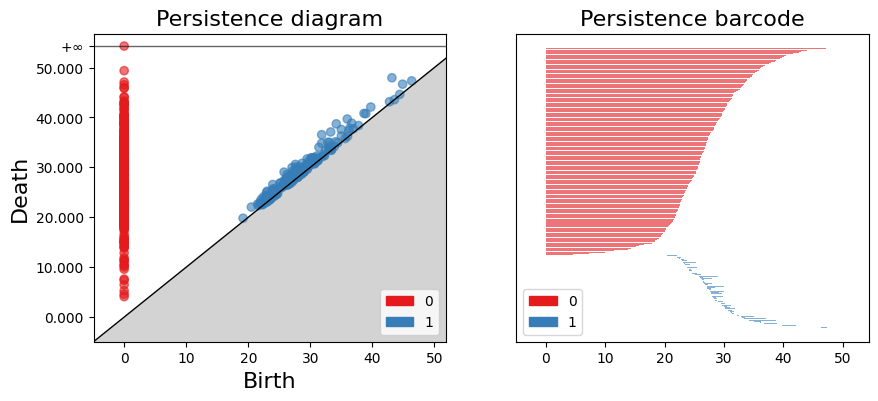

In [20]:
print("Betti numbers:", compute_betti_numbers(tree1, persist1))
plot_persistence(persist1)
plt.show()

# All Methods

In [21]:
paths, _ = get_embedding_paths(sub_dirs=['data/ivy'], levels=['method'])
data = paths_to_data(paths)

In [13]:
tree = gudhi.RipsComplex(points=data['embeds'], max_edge_length=40).create_simplex_tree(max_dimension=3)
persist = tree.persistence()

Betti numbers: [122, 360, 83]


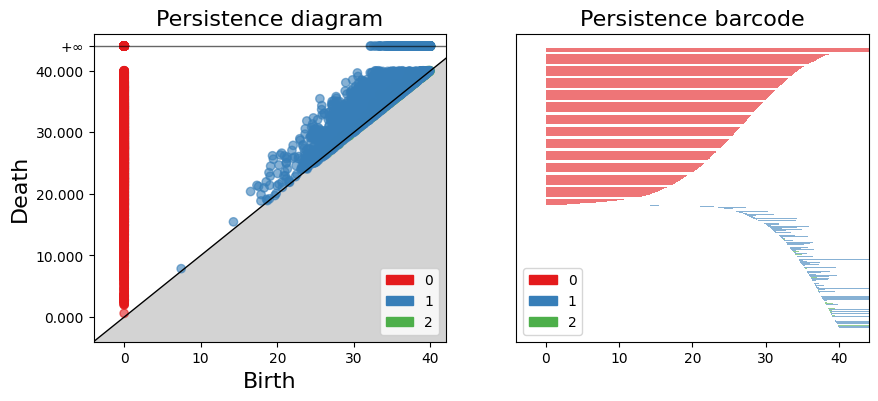

In [14]:
print("Betti numbers:", compute_betti_numbers(tree, persist))
plot_persistence(persist)
plt.show()

In [24]:
# 26 minutes
tree1 = gudhi.RipsComplex(points=data['embeds'], max_edge_length=49).create_simplex_tree(max_dimension=2)
persist1 = tree1.persistence()

Betti numbers: [1, 1]


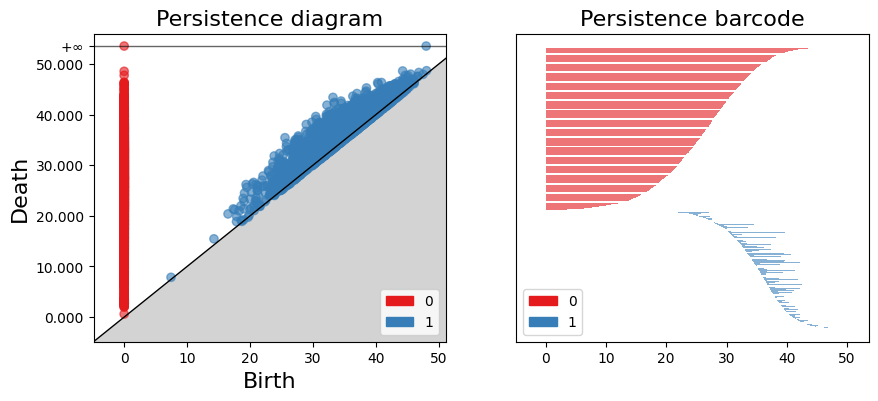

In [ ]:
print("Betti numbers:", compute_betti_numbers(tree1, persist1))
plot_persistence(persist1)
plt.show()

In [ ]:
# 16 minutes
tree2 = gudhi.RipsComplex(points=data['embeds'], max_edge_length=48).create_simplex_tree(max_dimension=2)
persist2 = tree2.persistence()

Betti numbers: [2, 3]


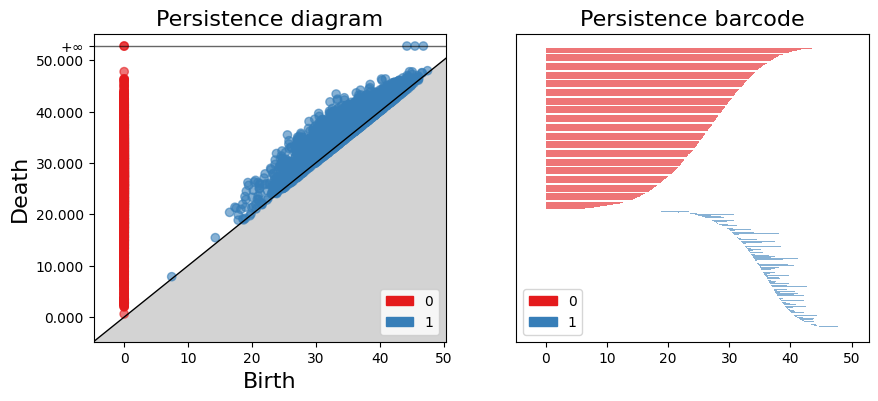

In [22]:
print("Betti numbers:", compute_betti_numbers(tree2, persist2))
plot_persistence(persist2)
plt.show()

### Classes/Methods by Locations

### Methods by Java File

In [23]:
# 17 minutes
betti_nums = {}
for i, dir in enumerate(all_java_files):
    clear_output()
    print(f'Working on Java file #{i}: {dir}')
    paths, levels = get_embedding_paths(sub_dirs=[dir], levels=['method'])
    data = paths_to_data(paths)
    data['levels'] = levels

    # Skip if no embeddings were collected
    if len(data['embeds']) == 0:
        continue
        
    tree = gudhi.RipsComplex(points=data['embeds'], max_edge_length=40).create_simplex_tree(max_dimension=3)
    persist = tree.persistence(homology_coeff_field=46337)

    betti_nums[dir] = compute_betti_numbers(tree, persist)

Working on Java file #487: data/ivy/util/url/URLHandlerRegistry


In [24]:
betti_nums

{'data/ivy/Ivy': [5, 1, 0],
 'data/ivy/Ivy14': [3, 0, 0],
 'data/ivy/Main': [3, 0, 0],
 'data/ivy/ant/AddPathTask': [2, 0, 0],
 'data/ivy/ant/AntBuildTrigger': [3, 0, 0],
 'data/ivy/ant/AntCallTrigger': [2, 0, 0],
 'data/ivy/ant/AntMessageLogger': [1, 1, 0],
 'data/ivy/ant/AntWorkspaceResolver': [11, 0],
 'data/ivy/ant/BuildOBRTask': [9],
 'data/ivy/ant/ConvertManifestTask': [4],
 'data/ivy/ant/EmptyFileSet': [3, 1],
 'data/ivy/ant/FixDepsTask': [4],
 'data/ivy/ant/IvyAntSettings': [7, 0, 0],
 'data/ivy/ant/IvyAntVariableContainer': [2, 0],
 'data/ivy/ant/IvyArtifactProperty': [1, 0],
 'data/ivy/ant/IvyArtifactReport': [5, 0, 0],
 'data/ivy/ant/IvyBuildList': [7, 2, 0],
 'data/ivy/ant/IvyBuildNumber': [3, 0, 0],
 'data/ivy/ant/IvyCacheFileset': [4],
 'data/ivy/ant/IvyCachePath': [2, 0],
 'data/ivy/ant/IvyCacheTask': [1],
 'data/ivy/ant/IvyCheck': [3],
 'data/ivy/ant/IvyCleanCache': [3],
 'data/ivy/ant/IvyConfigure': [4, 1, 0],
 'data/ivy/ant/IvyConflict': [6],
 'data/ivy/ant/IvyConvert

In [4]:
def load_token_embeddings_from_dir(java_dir):
    """
    Loads token-level embeddings from a specified `.java` directory and transforms 
    them into a matrix of shape N x 768.

    Args:
        java_dir (str): Directory containing `.json` files for a `.java` file.

    Returns:
        np.array: A matrix of shape N x 768 for all token embeddings.
    """
    point_cloud = []
    for filename in os.listdir(java_dir):
        if filename.endswith(".json"):
            with open(os.path.join(java_dir, filename), 'r') as f:
                data = json.load(f)
                # Only include token-level embeddings
                if "token" in filename:
                    embedding = np.squeeze(data[0])  # Remove the extra dimension (1)
                    point_cloud.append(embedding)

    # Convert to NumPy array
    if not point_cloud:
        raise ValueError(f"No token embeddings found in directory: {java_dir}")

    return np.array(point_cloud)

def GetBettiCurvesFromPointCloud(X, J, dim=3):
    """
    Computes the Betti curves of the Rips complex on the point cloud X.

    Args:
        X (np.array): Nx2 point cloud.
        J (np.array): Interval of filtration values.
        dim (int): Max dimension for Betti curves.

    Returns:
        np.array: Betti curves for the point cloud.
    """
    I = 2 * J
    tmax = max(I)
    rips = gudhi.RipsComplex(points=X, max_edge_length=tmax)
    st = rips.create_simplex_tree(max_dimension=dim)
    st.persistence(persistence_dim_max=True, homology_coeff_field=2)
    Diagrams = [st.persistence_intervals_in_dimension(i) for i in range(dim + 1)]
    BettiCurves = []
    step_x = I[1] - I[0]
    for diagram in Diagrams:
        bc = np.zeros(len(I))
        if len(diagram) != 0:
            diagram_int = np.clip(
                np.ceil((diagram[:, :2] - I[0]) / step_x), 0, len(I)
            ).astype(int)
            for interval in diagram_int:
                bc[interval[0] : interval[1]] += 1
        BettiCurves.append(np.reshape(bc, [1, -1]))
    return np.reshape(BettiCurves, (dim + 1, len(I)))


def compare_betti_curves(java_dir1, java_dir2, interval, dim=3):
    """
    Compares the Betti curves of two `.java` files.

    Args:
        java_dir1 (str): Directory of the first `.java` file.
        java_dir2 (str): Directory of the second `.java` file.
        interval (np.array): Interval for Betti curve calculation.
        dim (int): Maximal dimension to compute Betti curves.

    Returns:
        None: Visualizes the Betti curves of the two files.
    """
    # Load token embeddings
    point_cloud1 = load_token_embeddings_from_dir(java_dir1)
    point_cloud2 = load_token_embeddings_from_dir(java_dir2)
    print(f"Point Cloud 1 Shape: {point_cloud1.shape}")
    print(f"Point Cloud 2 Shape: {point_cloud2.shape}")

    # Compute Betti curves
    betti_curve1 = GetBettiCurvesFromPointCloud(point_cloud1, interval, dim)
    betti_curve2 = GetBettiCurvesFromPointCloud(point_cloud2, interval, dim)
    
    
    # Visualize comparison
    plt.figure(figsize=(10, 6))
    for i in range(dim + 1):
        plt.plot(interval, betti_curve1[i, :], label=f"File 1: Betti {i}")
        plt.plot(interval, betti_curve2[i, :], label=f"File 2: Betti {i}", linestyle='--')
    plt.xlabel("Filtration Value")
    plt.ylabel("Betti Number")
    plt.title("Betti Curve Comparison")
    plt.legend()
    plt.show()

    
    

In [6]:

# Specify directories for the two `.java` files
java_dir1 = "/home/cxiong/CSCI420_05/data/ivy/Ivy"  # Replace with actual directory
java_dir2 = "/home/cxiong/CSCI420_05/data/ivy/Ivy14"  # Replace with actual directory
interval = np.linspace(0, 1, 100)  # Interval for Betti curve calculation

# Compare Betti curves
compare_betti_curves(java_dir1, java_dir2, interval, dim=3)

KeyboardInterrupt: 

In [ ]:
java_dir1 = "/home/cxiong/CSCI420_05/data/ivy/Ivy"  # Replace with actual directory
point_cloud1 = load_token_embeddings_from_dir(java_dir1)
print(f"Point Cloud 1 Shape: {point_cloud1.shape}")
interval = np.linspace(0, 1, 100)
dim = 3
# Compute Betti curves
betti_curve1 = GetBettiCurvesFromPointCloud(point_cloud1, interval, dim)



# Visualize comparison
plt.figure()
plt.step(I, betti_curve1[0])
plt.ylim(0, max(betti_curve1[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, betti_curve1[1])
plt.ylim(0, max(betti_curve1[1])+1)
plt.ylim(0, 5)
plt.title('1-Betti curve')
plt.show()

Point Cloud 1 Shape: (3348, 768)
